In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
! ls /data/sg/ashutiwa/final_128/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_residual2vec_128_embs.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("airport").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_128/airport/'

DIRS = ['airport_one/', 'airport_two/', 'airport_three/', 'airport_four/', 'airport_five/']
DATASET = 'airport'

model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    "residual2vec": "_residual2vec_128_embs.npy"
    
    
}

M = list(model_to_embs.keys())
TEST_ADJ_FILE='/data/sg/ashutiwa/final_128/airport/airport_one/airport_test_adj.npz'
NUM_NODES=2898
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# residual2vec

In [8]:
model = "residual2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


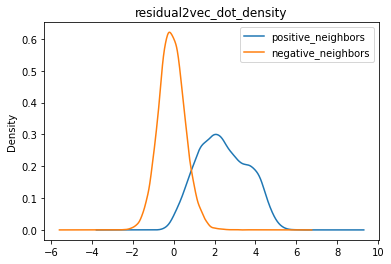

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 191.84it/s]


((14490, 2), 0.006705169434365809, 0.9726013242955047, 0.6846685143779456)

# deepwalk

In [11]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


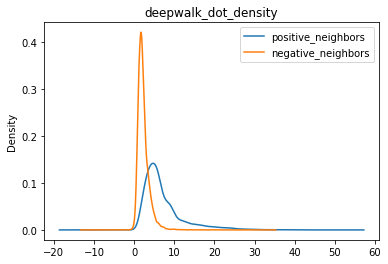

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 210.72it/s]


((14490, 2), 0.008096036662411819, 0.9079242693715242, 0.7482318031538178)

# node2vec

In [14]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


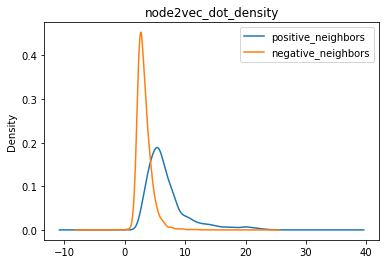

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 209.77it/s]


((14486, 2), 0.008220736086646738, 0.9082388027100872, 0.7477061635960849)

# fairwalk+deepwalk

In [17]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


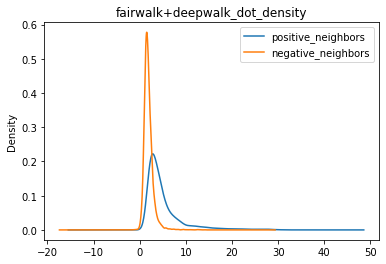

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 197.19it/s]


((14490, 2), 0.00783383400994355, 0.8871245459341714, 0.7314398922657573)

# fairwalk+node2vec

In [20]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 13702


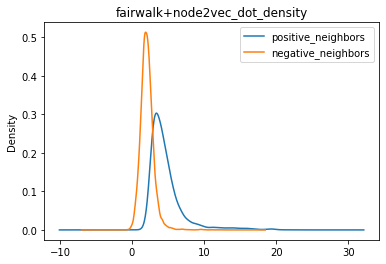

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 210.90it/s]


((14490, 2), 0.007869761202161905, 0.9344389738743449, 0.7323583700809917)

# crosswalk+deepwalk

In [23]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


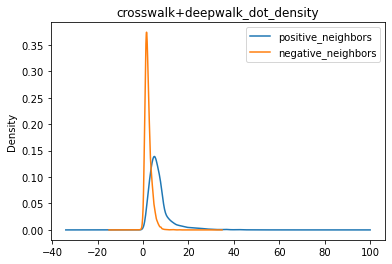

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 224.07it/s]


((14478, 2), 0.007846405864077678, 0.9057196011666987, 0.7376874146954271)

# crosswalk+node2vec

In [26]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


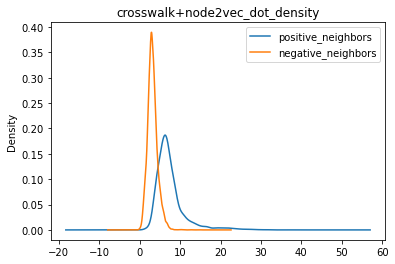

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 209.75it/s]


((14490, 2), 0.008276282881410246, 0.9434791388421062, 0.7476853491706005)

# GCN+deepwalk+random

In [29]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


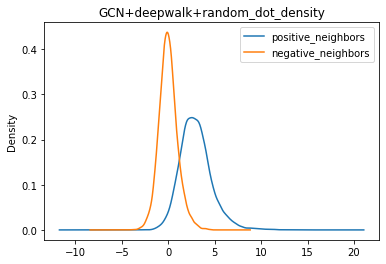

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 281.61it/s]


((14490, 2), 0.007983507095560765, 0.94473046508387, 0.7461972322795704)

# GCN+deepwalk+r2v

In [32]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 13702


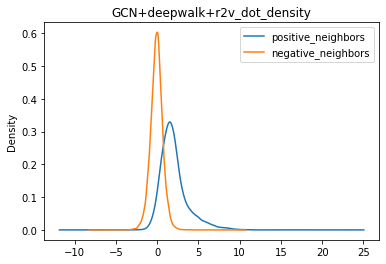

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 324.11it/s]


((14490, 2), 0.007242763357793742, 0.9148917511453473, 0.7165372638462105)

# GCN+node2vec+random

In [35]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


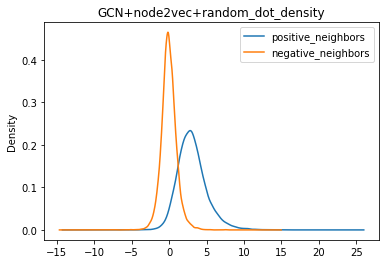

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 324.69it/s]


((14490, 2), 0.008113480134165851, 0.9400831274137418, 0.7460007227356782)

# GCN+node2vec+r2v

In [38]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


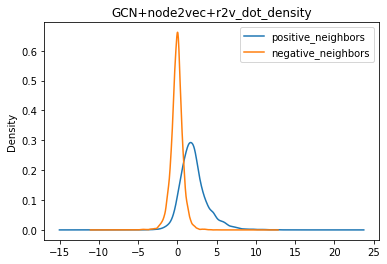

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 318.02it/s]


((14490, 2), 0.007688362258953796, 0.902669841664433, 0.7302510864920002)

# GAT+deepwalk+random

In [41]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


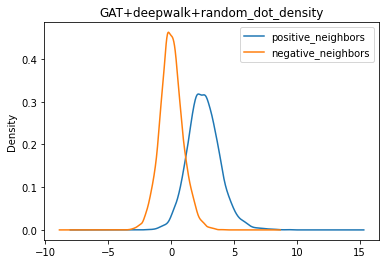

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 313.80it/s]


((14490, 2), 0.007880156379533546, 0.9534390736054672, 0.7437384050652631)

# GAT+deepwalk+r2v

In [44]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


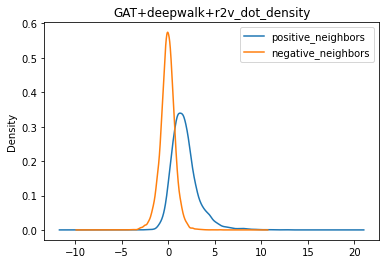

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 308.45it/s]


((14490, 2), 0.006850331518121618, 0.8989834014261187, 0.6982075296405743)

# GAT+node2vec+random

In [47]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


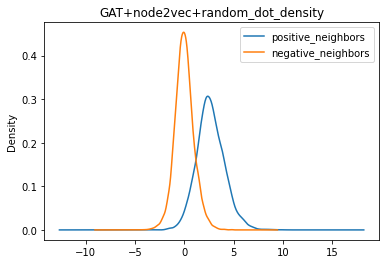

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 312.10it/s]


((14490, 2), 0.008119618037261732, 0.9444084588354306, 0.7435076706870463)

# GAT+node2vec+r2v

In [50]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


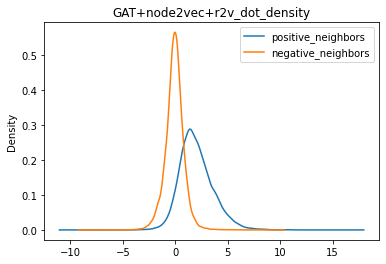

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 319.30it/s]


((14490, 2), 0.007835100347166625, 0.8953394843353428, 0.72831512243157)

# plot statistical parity scores

# gini sp scores

residual2vec 0.6846685143779456
deepwalk 0.7482318031538178
node2vec 0.7477061635960849
fairwalk+deepwalk 0.7314398922657573
fairwalk+node2vec 0.7323583700809917
crosswalk+deepwalk 0.7376874146954271
crosswalk+node2vec 0.7476853491706005
GCN+deepwalk+random 0.7461972322795704
GCN+deepwalk+r2v 0.7165372638462105
GCN+node2vec+random 0.7460007227356782
GCN+node2vec+r2v 0.7302510864920002
GAT+deepwalk+random 0.7437384050652631
GAT+deepwalk+r2v 0.6982075296405743
GAT+node2vec+random 0.7435076706870463
GAT+node2vec+r2v 0.72831512243157


Text(0.5, 1.0, 'gini statistical parity scores')

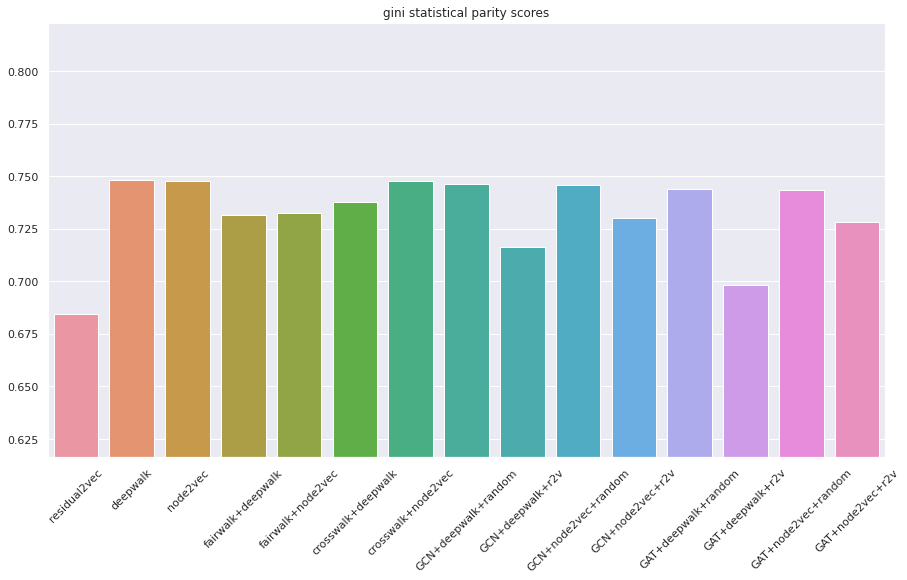

In [53]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

residual2vec 0.006705169434365809
deepwalk 0.008096036662411819
node2vec 0.008220736086646738
fairwalk+deepwalk 0.00783383400994355
fairwalk+node2vec 0.007869761202161905
crosswalk+deepwalk 0.007846405864077678
crosswalk+node2vec 0.008276282881410246
GCN+deepwalk+random 0.007983507095560765
GCN+deepwalk+r2v 0.007242763357793742
GCN+node2vec+random 0.008113480134165851
GCN+node2vec+r2v 0.007688362258953796
GAT+deepwalk+random 0.007880156379533546
GAT+deepwalk+r2v 0.006850331518121618
GAT+node2vec+random 0.008119618037261732
GAT+node2vec+r2v 0.007835100347166625


Text(0.5, 1.0, 'statistical parity scores')

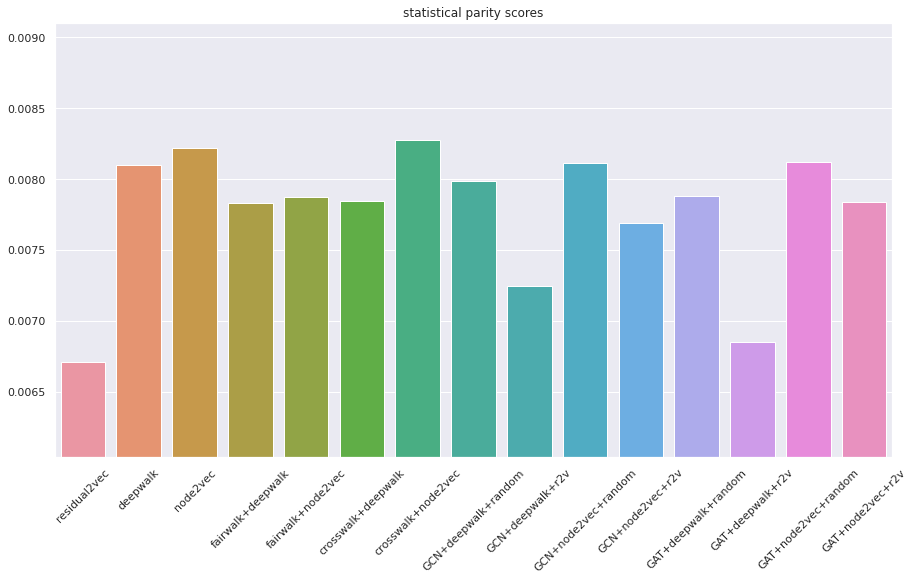

In [54]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

residual2vec 0.9726013242955047
deepwalk 0.9079242693715242
node2vec 0.9082388027100872
fairwalk+deepwalk 0.8871245459341714
fairwalk+node2vec 0.9344389738743449
crosswalk+deepwalk 0.9057196011666987
crosswalk+node2vec 0.9434791388421062
GCN+deepwalk+random 0.94473046508387
GCN+deepwalk+r2v 0.9148917511453473
GCN+node2vec+random 0.9400831274137418
GCN+node2vec+r2v 0.902669841664433
GAT+deepwalk+random 0.9534390736054672
GAT+deepwalk+r2v 0.8989834014261187
GAT+node2vec+random 0.9444084588354306
GAT+node2vec+r2v 0.8953394843353428


Text(0.5, 1.0, 'roc scores')

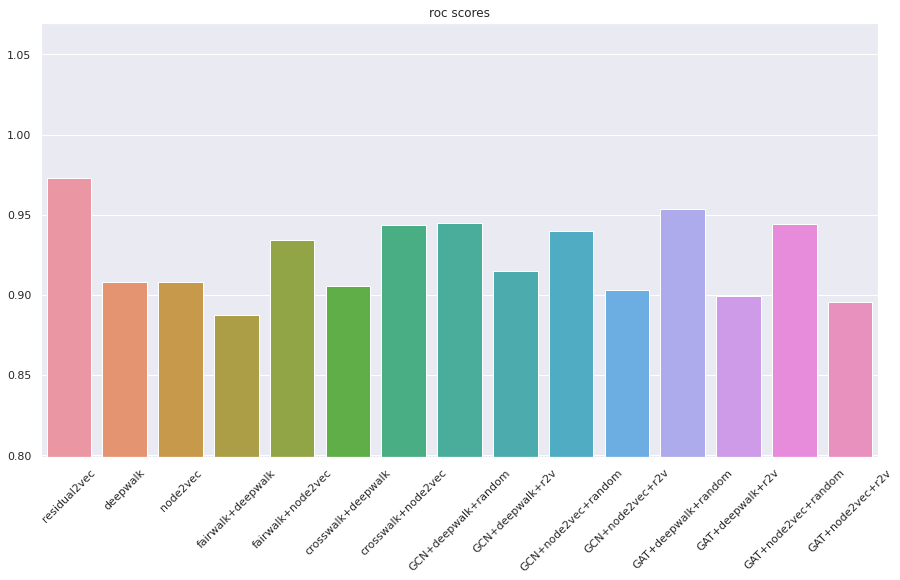

In [55]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [56]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 315.17it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 300.49it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 295.31it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

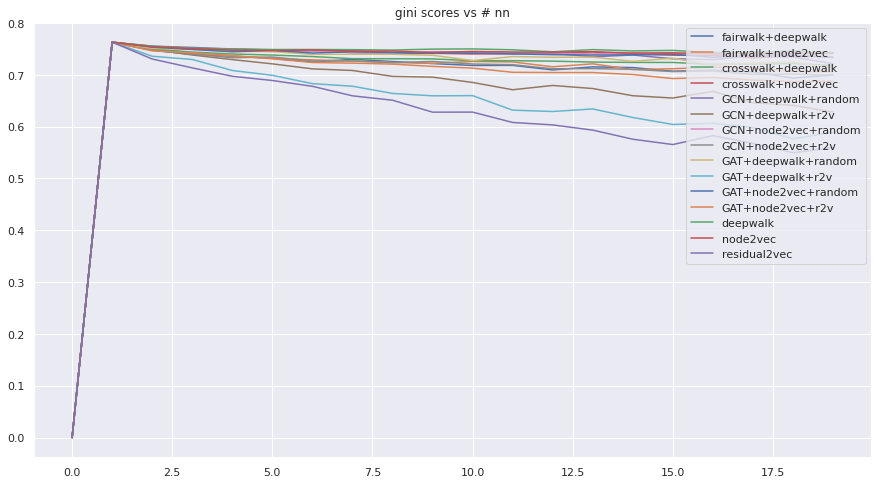

In [57]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

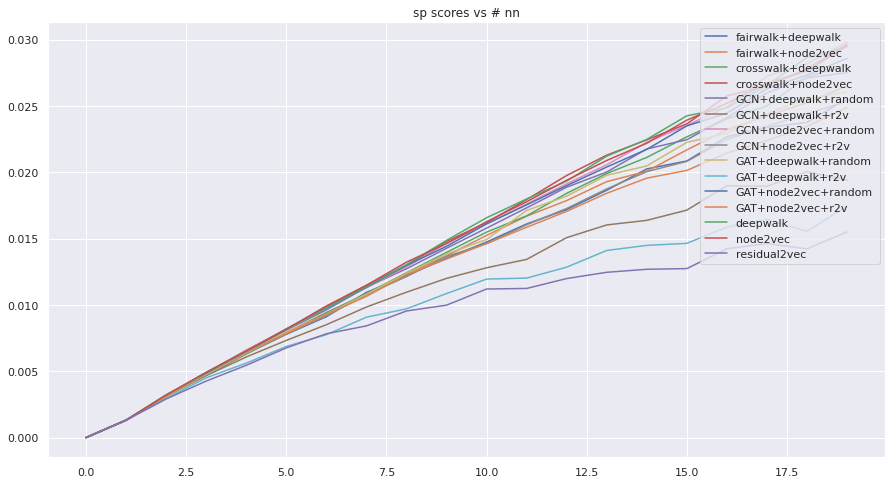

In [58]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [59]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected e

Text(0.5, 1.0, 'roc scores')

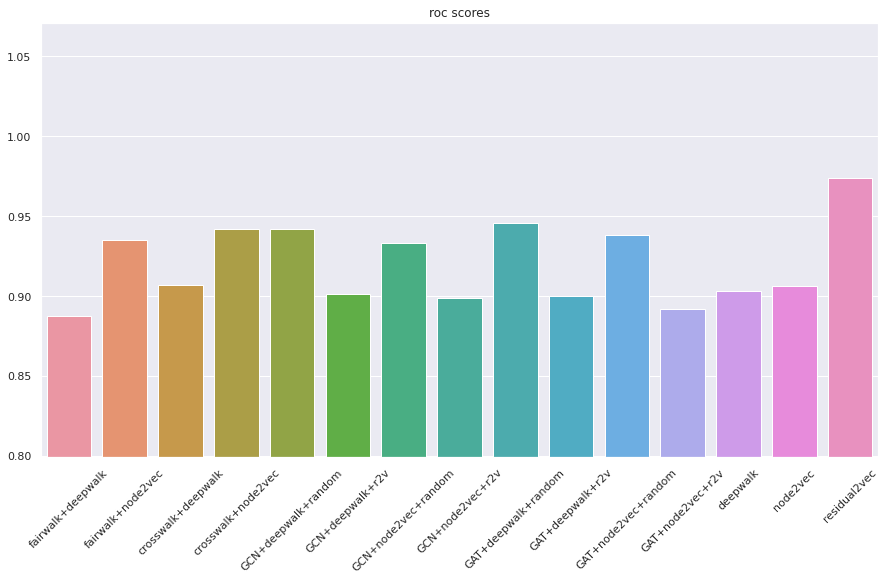

In [60]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 336.97it/s]

fairwalk+deepwalk 0.007722210905676012
fairwalk+node2vec 0.00781656807542068
crosswalk+deepwalk 0.00799455933192562
crosswalk+node2vec 0.008164833902768055
GCN+deepwalk+random 0.007949318143830444
GCN+deepwalk+r2v 0.007313599742218732
GCN+node2vec+random 0.00819359279626149
GCN+node2vec+r2v 0.007951391974962824
GAT+deepwalk+random 0.007908633899489405
GAT+deepwalk+r2v 0.006925180191766101
GAT+node2vec+random 0.008231366259193976
GAT+node2vec+r2v 0.007798535264194234
deepwalk 0.008126986718663432
node2vec 0.008266708746072183
residual2vec 0.006606066268203587


Text(0.5, 1.0, 'statistical parity scores')

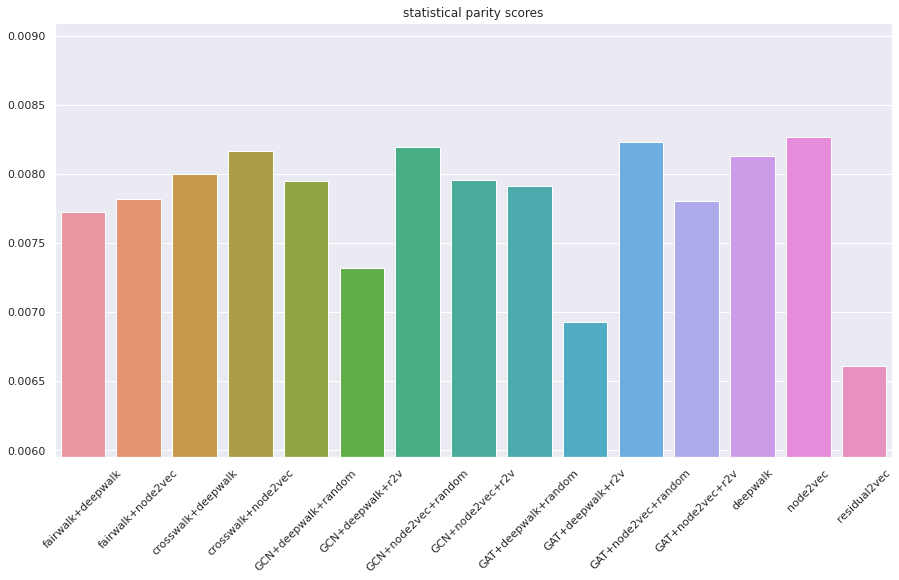

In [61]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.730919193566441
fairwalk+node2vec 0.7304311342452035
crosswalk+deepwalk 0.7424660438274036
crosswalk+node2vec 0.7452259686186996
GCN+deepwalk+random 0.7440221312308044
GCN+deepwalk+r2v 0.7183414815686934
GCN+node2vec+random 0.7458260692139275
GCN+node2vec+r2v 0.7348996849658531
GAT+deepwalk+random 0.7439057847624425
GAT+deepwalk+r2v 0.7028538961224985
GAT+node2vec+random 0.7470632425493353
GAT+node2vec+r2v 0.7285780817998264
deepwalk 0.7486849873836963
node2vec 0.7473933140741763
residual2vec 0.6848941850581702


Text(0.5, 1.0, 'gini statistical parity scores')

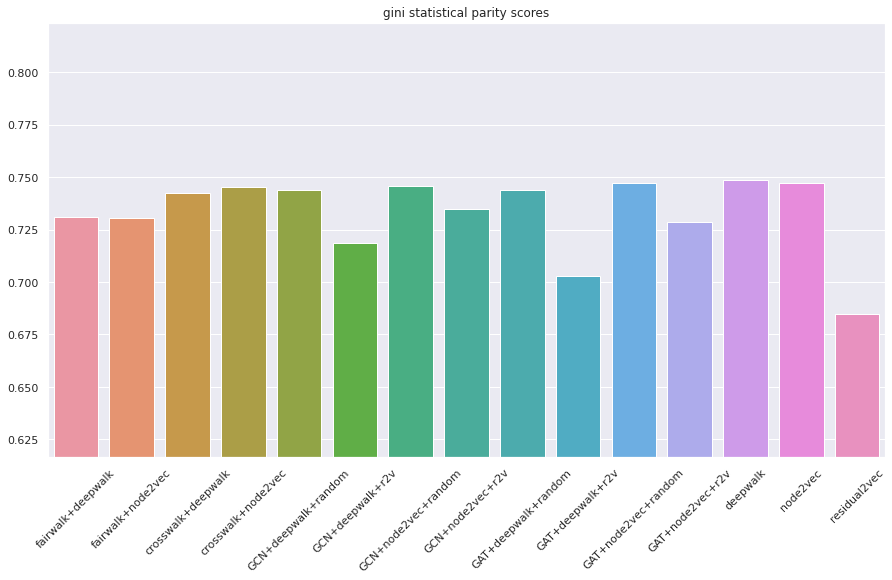

In [62]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [63]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected e

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 302.62it/s]
